# 2. Automatic Learning

In the previous part, we used human intuition to spot patterns in data.

We then used those patterns to predict the price of houses even when we did not have data.

In this part, we will try to create an algorithm for **_"learning"_** the values of **_m_** and **_b_** from the data.

This important small step will allow us to eventually approximate any function.

First, as usual, some initialization, and let's load up our toy data:

In [1]:
# Initialization stuff
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
import random
import torch
#from scripts.helper import *
plt.style.use('ggplot')
# For reproducibility
random.seed(0)
torch.manual_seed(0)
np.random.seed(0)


# Let's write this up as a function as well
def y(m, b, x):
    return m * x + b

# Can we define a function with a fixed m and b that returns the value of y?
# Of course we can
from functools import partial
def get_y_hat_function(m, b):
    return partial(y, m, b)


data = np.asarray([[1, 300000], [2, 500000], [3, 700000], [4, 900000], [5, 1100000]])
data

array([[      1,  300000],
       [      2,  500000],
       [      3,  700000],
       [      4,  900000],
       [      5, 1100000]])

### Loss Function

In the previous section, we tried to guess values of **_m_** and **_b_** and observed how the output result changed. Then based on how far the output result was from the actual result, we re-adjusted the values of **_m_** and **_b_** to finally arrive at the perfect values for **_m_** and **_b_** (given that we are living in an ideal world).

So let us define another function called the **_loss_** function that determines how far the **_"output"_** or **_"predicted"_** value is from the **_"actual"_** or **_"ground truth"_** value.

Now if we denote the output of our approximation as **_ŷ_** (pronounced y hat), and we further denote the actual value as **_y_**, then we can define a **_loss_** function as the square of the difference between them.

This is a good measure as it gives us a measure of how far away **_ŷ_** is from **_y_**

In [2]:
%%latex
\begin{equation}
L(ŷ, y) = (ŷ-y)^2
\end{equation}

<IPython.core.display.Latex object>

Recall that given a guessed value of **_m_** as 150,000 and **_b_** as 100,000, we could get a function to get **_ŷ_** like this:

In [3]:
y_hat = get_y_hat_function(m=150000, b=100000)
# Show the "predicted" value ŷ for a 3 bedroom house
y_hat(3)

550000

We can also define a y function that gets the actual value:

In [4]:
def yfunc(x):
    # We can only get values for items that are present in the dataset
    if x > data.shape[0] or x < 1:
        return None
    else:
        return data[x-1,1]

# Actual value y for a 3 bedroom house
yfunc(3)

700000

We can also define the loss function:

In [5]:
def loss(y_hat, y):
    return (y_hat - y) ** 2

# What is the value for the loss for a 3 bedroom house?
loss(y_hat(3), yfunc(3))

22500000000

What if we changed **_m_** as 170,000 and **_b_** as 100,000?

In [7]:
y_hat = get_y_hat_function(m=170000, b=100000)

loss(y_hat(3), yfunc(3))

8100000000

We see that the loss decreased! That means this new guess is better than our previous guess.

But we see that the loss is measured over a single data point (or row) in our data - in this case for the data point of a 3 bedroom apartment.

What we really want is a measure of how far off we are from an ideal solution over more than one row.

For this we define **_cost_** function which we can simply take as the average of the loss for each row.

### Cost Function

The cost function is simply the average of the losses over all **_k_** rows:

In [8]:
%%latex
\begin{equation}
J(w, b) = \frac{1}{m} \sum_{n=1}^{k} L_i(ŷ_i, y_i)
\end{equation}

<IPython.core.display.Latex object>

Notice that in the above equation, we have used **_w_** instead of **_m_**. **_w_** is more machine learning parlance and represents a weight. Thus, given a _weight_ **_w_** and and _bias_ **_b_**, We can calculate the cost - a measure of how far away our guess is from the actual values of **_w_** and **_b_**.

Next, lets define this in Python for clarity:

In [10]:
def J(w, b):
    y_hat = get_y_hat_function(m=w, b=b)
    losses = []
    for row in range(data.shape[0]):
        row_loss = loss(y_hat(row+1), yfunc(row+1))
        losses.append(row_loss)
    return sum(losses) / len(losses)

# What is the loss for w=170000, b=100000
J(170000, 100000)

9900000000.0

So, now we have a measure of how correct or incorrect our guesses are for **_w_** and **_b_** over the entire dataset.

Let's try **_w_** as 190,000 and **_b_** as 100,000

In [11]:
J(190000, 100000)

1100000000.0

The cost decreased! So we are on the right track, lets try **_w_** as 210,000 and **_b_** as 100,000

In [12]:
J(210000, 100000)

1100000000.0

The cost is the same! That means w must lie in between:

In [13]:
J(200000, 100000)

0.0

Thus we see, that the best value is achieved when the cost is 0, **_w_** is 200,000 and **_b_** is 100,000.

Let us visualize this by looking at the value of **_J_** or cost as **_w_** varies between 190,000 and 210,000

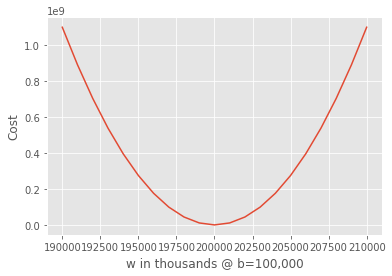

In [14]:
x_axis = []
y_axis = []
for w in range(190000, 210001, 1000):
    x_axis.append(w)
    y_axis.append(J(w, 100000))
# Plotting first column vs second column
plt.plot(x_axis, y_axis)
# Label the axes
plt.ylabel('Cost')
plt.xlabel('w in thousands @ b=100,000')
plt.show()

Excellent! Now we can see how this cost function varies as the values of **_w_** and **_b_** change.

Now, given a **_w_** and **_b_**, we can calculate the slope or **_gradient_** of the **_cost_** function to determine how to adjust the values of **_w_** and **_b_**.

In [15]:
Image("images/gradient.png")

Now, if we calculate the gradient of the cost function and adjust the value of **_w_** and **_b_** in some proportion to the gradient, then we would be moving closer to the minima of the cost function.

Recall from calculus that the gradient of a curve is its derivative. In this case, we want to calculate the deriviatives of **_J_** with respect to **_w_** and **_b_**

In [16]:
%%latex
\begin{equation}
J(w, b) = \frac{1}{m} \sum_{n=1}^{k} L_i(ŷ_i, y_i)
\end{equation}

Therefore:
\begin{equation}
\frac{dJ(w, b)}{dw} = \frac{1}{m} \sum_{n=1}^{k} \frac{dL_i(ŷ_i, y_i)}{dw} = \frac{1}{m} \sum_{n=1}^{k} \frac{d(((wx_i+b)-y_i)^2)}{dw} = \frac{2}{m} \sum_{n=1}^{k} x_i(wx_i - y_i + b)
\end{equation}

and

\begin{equation}
\frac{dJ(w, b)}{db} = \frac{1}{m} \sum_{n=1}^{k} \frac{dL_i(ŷ_i, y_i)}{db} = \frac{1}{m} \sum_{n=1}^{k} \frac{d(((wx_i+b)-y_i)^2)}{db} = \frac{2}{m} \sum_{n=1}^{k} (wx_i - y_i + b)
\end{equation}

<IPython.core.display.Latex object>

To verify the calculus, you can use the following site:

[https://www.derivative-calculator.net/](https://www.derivative-calculator.net/)

Let's define functions for the above computations:

In [17]:
def dJ_dw(w, b):
    accumulate = 0
    for i in range(data.shape[0]):
        x_i = data[i,0]
        y_i = data[i,1]
        accumulate += x_i * (w * x_i - y_i + b)
    derivative = (2 / data.shape[0]) * accumulate
    return derivative

def dJ_db(w, b):
    accumulate = 0
    for i in range(data.shape[0]):
        x_i = data[i,0]
        y_i = data[i,1]
        accumulate += (w * x_i - y_i + b)
    derivative = (2 / data.shape[0]) * accumulate
    return derivative

# Let's check our calculations. Both derivates should be 0 when w = 200,000 and b=100,000
print("Derivative with respect to w is {}".format(dJ_dw(200000, 100000)))
print("Derivative with respect to b is {}".format(dJ_db(200000, 100000)))

Derivative with respect to w is 0.0
Derivative with respect to b is 0.0


Excellent! Now we have functions to calculate the gradients of the **_cost_** function with respect to **_w_** and **_b_**

Now, if we select some random  **_w_** and **_b_** and update them each time in the direction of the gradient by some amount proportional to the gradient, we should gradually reach optimum values of **_w_** and **_b_**

To formalize this, **_w_** and **_b_** will be updated like the following:

In [18]:
%%latex
\begin{equation}
w = w - \alpha \frac{dJ(w, b)}{dw}
\end{equation}

\begin{equation}
b = b - \alpha \frac{dJ(w, b)}{db}
\end{equation}

<IPython.core.display.Latex object>

In the above equations, 𝛼 is known as the **_learning rate_**

Let's see what values we arrive at in 10000 iterations!

In [19]:
alpha = 0.01
w = 150000
b = 80000
for _ in range(10000):
    w = w - alpha * dJ_dw(w, b)
    b = b - alpha * dJ_db(w, b)

print("Final value of w is {}".format(w))
print("Final value of b is {}".format(b))

Final value of w is 200000.00000000087
Final value of b is 99999.99999999703


Congratulations! The machine has learnt the values of **_w_** and **_b_** from the data!

To convince yourself that this works, let's start with different random values of **_w_** and **_b_**:

In [20]:
alpha = 0.01
w = 1000
b = 8000
for _ in range(10000):
    w = w - alpha * dJ_dw(w, b)
    b = b - alpha * dJ_db(w, b)

print("Final value of w is {}".format(w))
print("Final value of b is {}".format(b))

Final value of w is 200000.00000000087
Final value of b is 99999.99999999703


Or we could be even more extreme!

In [21]:
alpha = 0.01
w = 1
b = 8
for _ in range(10000):
    w = w - alpha * dJ_dw(w, b)
    b = b - alpha * dJ_db(w, b)

print("Final value of w is {}".format(w))
print("Final value of b is {}".format(b))

Final value of w is 200000.00000000087
Final value of b is 99999.99999999703


This method of learning the values of parameters is known as **_Gradient Descent_**. 

To better understand what's going on, lets plot the value of **_cost function_**, for the first 20 iterations:

Final value of w is 212786.07270510666
Final value of b is 49765.40383212933


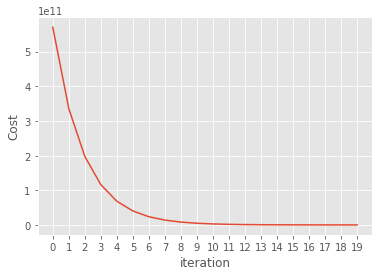

In [22]:
alpha = 0.01
w = 1
b = 8
cost_function_values = []
for iteration in range(20):
    cost_function_values.append(J(w, b))
    w = w - alpha * dJ_dw(w, b)
    b = b - alpha * dJ_db(w, b)
    
print("Final value of w is {}".format(w))
print("Final value of b is {}".format(b))

# Plotting the cost as iterations increase
y_axis = cost_function_values
x_axis = range(len(cost_function_values))
plt.plot(x_axis, y_axis)
# Plot x axis ticks
plt.xticks(x_axis)
# Label the axes
plt.ylabel('Cost')
plt.xlabel('iteration')
plt.show()

So now we see what's going on! We have written an algorithm that manages to gradually reduce the value of the cost function, moving closer and closer to its minimum value.

**Question**: Why does the value of the cost function decrease rapidly in the first 10 iterations and then decreases more slowly?


**Question**: What would happen if we picked a learning rate 𝛼 that was too large?


Final value of w is -49069.610980773345
Final value of b is 176662.19953077816


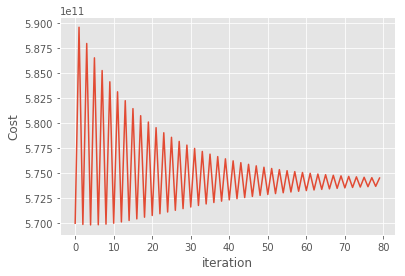

In [23]:
alpha = 0.1
w = 1
b = 8
cost_function_values = []
for iteration in range(80):
    cost_function_values.append(J(w, b))
    w = w - alpha * dJ_dw(w, b)
    b = b - alpha * dJ_db(w, b)
    
print("Final value of w is {}".format(w))
print("Final value of b is {}".format(b))

# Plotting the cost as iterations increase
y_axis = cost_function_values
x_axis = range(len(cost_function_values))
plt.plot(x_axis, y_axis)
# Plot x axis ticks
#plt.xticks(x_axis)
# Label the axes
plt.ylabel('Cost')
plt.xlabel('iteration')
plt.show()

## What just happened?

1. We started of with the intuition that we needed a way to measure how far away our prediction was from the actual value.
2. Based on the intuition, we defined a **_loss function_** that measured how far a prediction was for a single data-point (row) in our data set.
3. Then we realised what we wanted was a measure of **_loss_** across the whole dataset.
4. So, then we defined a **_cost function_** as a simple average of the **_loss_** across the whole dataset.
5. We then used some mathematics to figure out the gradient of the **_cost function_** with respect to **_w_** and **_b_**
6. Then we used the gradient to iteratively update **_w_** and **_b_** until they **_converged_** to their optimal values.
7. We examined the effect of having a learning rate **_𝛼_** that is too large.

## But a house doesn't just have bedrooms!

This was really a toy problem to illustrate how the basic gradient descent algorithm works. We used a bit of mathematics to illustrate the fundamentals. 

Fortunately for us, we don't need to define derivative functions to solve these type of problems. There are libraries that can do this for us!

In the next section, we will look at more complex formulations and how libraries can help us!